# $^{228}\text{Th}$

Description...

In [1]:
import sys
sys.path.append('/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/libs')

import crudo
import fit_functions as ff
from   iminuit import Minuit                                                                                                # type: ignore
from   iminuit.cost import LeastSquares                                                                                     # type: ignore
import matplotlib.pyplot as plt                                                                                             # type: ignore
import numpy as np                                                                                                          # type: ignore
import os
import pandas as pd                                                                                                         # type: ignore
import pickle
import plotting_tools as pt
import tables as tb                                                                                                         # type: ignore
from   scipy.optimize import curve_fit                                                                                      # type: ignore
import scipy.stats as stats                                                                                                 # type: ignore

%load_ext autoreload
%autoreload 2

## Runs Information

In [2]:
# ----- Run Information ----- #
run_id   = 15205
run_long = 74538
run_OK   = 1130809
run_LOST = 866339
run_DAQe = run_OK / (run_OK + run_LOST)

h5_filename = f'run_{run_id}_custom_sophronia.h5'

### Selected Data

In [3]:
# Personal data directory
data_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/data/'
h5_path = os.path.join(data_dir, h5_filename)
print('Reading file:', os.path.basename(h5_path))

# Check if the file exists
if not os.path.isfile(h5_path):
    print(f"File {h5_path} does not exist.")

# Table paths inside the HDF5 file. These are the keys used to access the datasets.
dorothea  = 'DST/Events'
sophronia = 'RECO/Events'

Reading file: run_15205_custom_sophronia.h5


#### Sophronia

In [4]:
try:
    data_reco = pd.read_hdf(h5_path, key=sophronia, columns=['event', 'time', 'X', 'Y', 'Z', 'Q', 'E', 'Ec'])
except KeyError:
    print(f"'{sophronia}' table not found in this file.")

## Preliminary

### Cleaning Dataframes

Let's:

- Drop hits with negative $Z$ and $E_{c}$ (even NaN values).
- Correct the $Z$ values 'cause in the Sophronia config file they use $v_{\text{drift}} = 1\,\text{mm/}\mu\text{s}$. 
  <br>According to **DocDB 1773**, on the end of March 2025, the value was $v_{\text{drift}} = 0.865\,\text{mm/}\mu\text{s}$.

In [5]:
# Global
V_drift = 0.865     # in [mm/μs]

# Drop Nan and negative Ec, Z values
data_reco = data_reco.dropna(subset=['Z', 'Ec']).copy()
data_reco = data_reco[data_reco['Z'] >= 0].copy()
data_reco = data_reco[data_reco['Ec'] >= 0].copy()

# Compute the actual Z position
data_reco.insert(data_reco.columns.get_loc('Q'), 'Zc', data_reco['Z'] * V_drift)

### Energy Correction by Lifetime

From **DocDB 1773**, on the end of March 2025, the electron lifetime was $\tau = 25\,\mu\text{s}$ ($E_{0}$ value is not important in the correction).

In [6]:
# Global
LT_fit = 1, 25e3  # Lifetime fit values in [PE] and [μs]

data_reco = crudo.correct_S2e_LT(data_reco, LT_fit, DT_column='Z', S2e_column='Ec', output_column='Ec_LT')      # Energy by lifetime

### Event-level Dataframe

In [7]:
# Group sophronia data by event
reco_evt  = data_reco.groupby('event')
events_df = []

for i, event in enumerate(reco_evt):

    # Event info
    event_id   = event[0]
    event_data = event[1]

    # Variables
    T = event_data['time']
    X = event_data['X']
    Y = event_data['Y']
    Z = event_data['Zc']
    E = event_data['Ec_LT']

    # Compute event-level weighted averages and sums
    T_evt = np.mean(T)             # Mean time
    E_evt = np.sum(E)              # Total energy
    X_evt = np.sum(E * X) / E_evt  # Energy-weighted X
    Y_evt = np.sum(E * Y) / E_evt  # Energy-weighted Y
    Z_evt = np.sum(E * Z) / E_evt  # Energy-weighted Z

    # Create a dataframe for the event-level information
    df = pd.DataFrame({'event': [event_id], 'time': [T_evt], 'X': [X_evt], 'Y': [Y_evt], 'Zc': [Z_evt], 'E': [E_evt]})
    events_df.append(df)

# Combine event-level dataframes for the run
data_event = pd.concat(events_df, ignore_index=True)

## Containment Cut

In [ ]:
# Containment limits definition
Q_low = 10      # in [PE]  
Z_low = 20     # in [mm]
Z_up  = 1167    # in [mm]
R_up  = 400     # in [mm]

# Cleaning spurious hits
data_reco = data_reco[data_reco['Q'] > Q_low].copy()

# ----- Selecting Events Fully Contained ----- #
reco_evt = data_reco.groupby('event')
events_drop = set()

for i, event in enumerate(reco_evt):

    # Event info
    event_id   = event[0]
    event_data = event[1]

    # Variables
    R_hits = np.sqrt(event_data['X']**2 + event_data['Y']**2)
    Z_hits = event_data['Zc']

    # Maximum Z and R values
    min_Z = Z_hits.min()
    max_Z = Z_hits.max()
    max_R = R_hits.max()

    # Apply containment limits
    if  min_Z < Z_low or max_Z > Z_up or max_R > R_up:
        events_drop.add(event_id)

print(f"Identified {len(events_drop)} events to drop due to containment.")

# Drop events from the data
if events_drop:
    data_reco_CC  = data_reco[~data_reco['event'].isin(events_drop)].copy()
    data_event_CC = data_event[~data_event['event'].isin(events_drop)].copy()
else:
    print("No events to drop.")

Identified 70846 events to drop due to containment.


## $Z$ Distributions

#### Hit-level

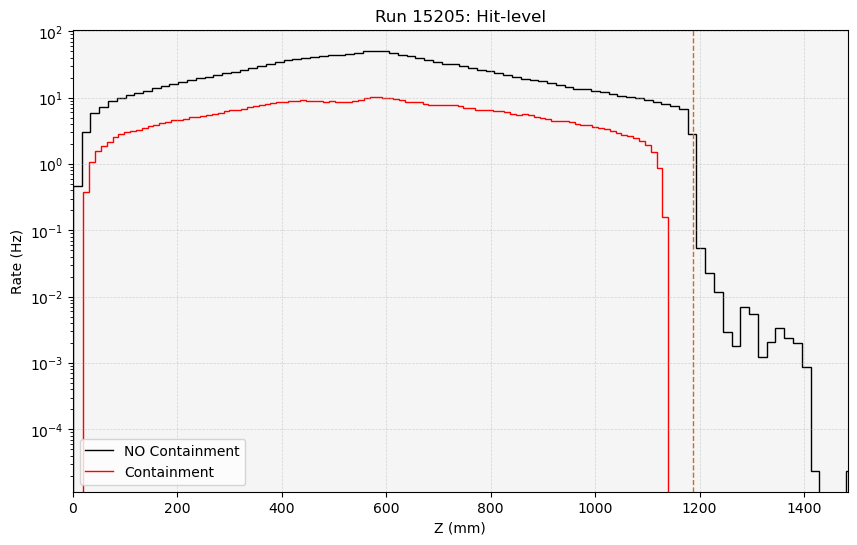

In [37]:
# Global
n_bins = 100

plt.figure(figsize=(10, 6))
color_idx = 0

for label, dataset in zip(['NO Containment', 'Containment'], [data_reco, data_reco_CC]):

    # Variables
    Z = dataset['Zc']

    # Histogram: normalized by corrected DAQ data taking time
    Z_counts, Z_edges = np.histogram(Z, bins=n_bins)
    Z_rate = Z_counts / (run_long * run_DAQe)

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, 
               label=label, fill=False, lw=1.0, ec=pt.hist_colors[(color_idx*1) % len(pt.hist_colors)])
    color_idx += 1

plt.axvline(x=pt.N100_hei, c='chocolate', ls='--', lw=1.0)        # Longitudinal limit

# Styling
plt.xlabel('Z (mm)')
plt.xlim(0, 1.25*pt.N100_hei)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title(f'Run {run_id}: Hit-level')
plt.legend(loc='lower left')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()


#### Event-level

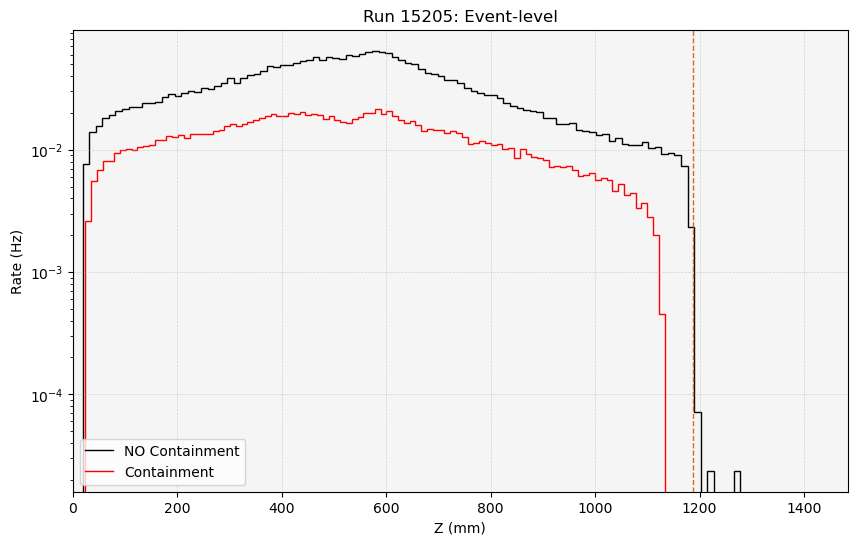

In [38]:
# Global
n_bins = 100

plt.figure(figsize=(10, 6))
color_idx = 0

for label, dataset in zip(['NO Containment', 'Containment'], [data_event, data_event_CC]):

    # Variables
    Z = dataset['Zc']

    # Histogram: normalized by corrected DAQ data taking time
    Z_counts, Z_edges = np.histogram(Z, bins=n_bins)
    Z_rate = Z_counts / (run_long * run_DAQe)

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, 
               label=label, fill=False, lw=1.0, ec=pt.hist_colors[(color_idx*1) % len(pt.hist_colors)])
    color_idx += 1

plt.axvline(x=pt.N100_hei, c='chocolate', ls='--', lw=1.0)        # Longitudinal limit

# Styling
plt.xlabel('Z (mm)')
plt.xlim(0, 1.25*pt.N100_hei)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title(f'Run {run_id}: Event-level')
plt.legend(loc='lower left')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

## $XY$ Distributions

### Hits

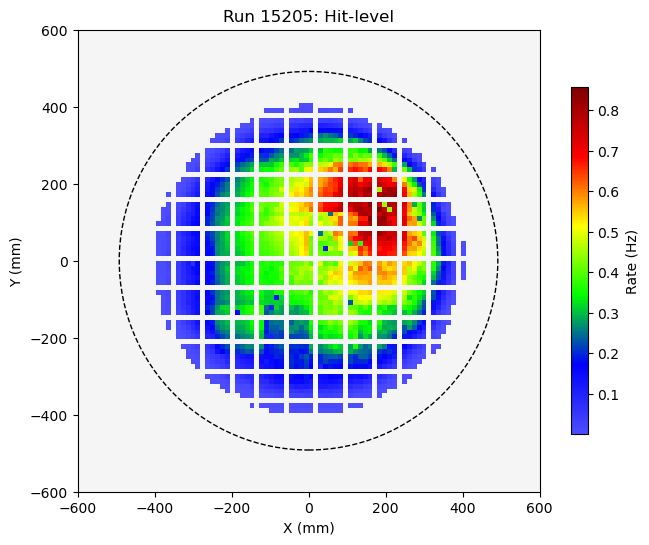

In [42]:
# Global
n_bins = 95

# Variables
X = data_reco_CC['X']
Y = data_reco_CC['Y']

# Mapping
XY_hit_map, ex, ey = pt.mapping(X, Y, xy_bins=n_bins, pos=True)
XY_rate = XY_hit_map / (run_long * run_DAQe)                                    # Normalized to rate      
XY_rate = np.ma.masked_where(XY_rate == 0, XY_rate)                             # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
im = plt.pcolormesh(ex, ey, XY_rate.T, cmap=pt.custom_hsv, shading='auto')
plt.colorbar(im, label='Rate (Hz)', shrink=0.75)
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title(f'Run {run_id}: Hit-level')

plt.gca().add_patch(pt.plot_circle(pt.N100_rad))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor("whitesmoke")
plt.show()

### Event

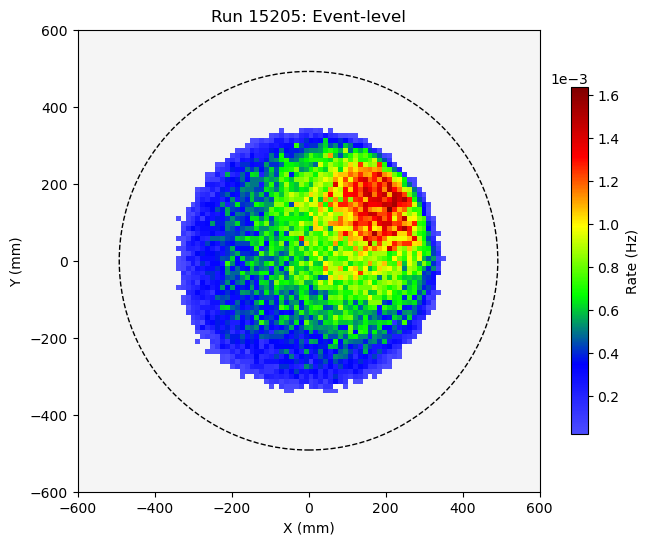

In [41]:
# Global
n_bins = 95

# Variables
X = data_event_CC['X']
Y = data_event_CC['Y']

# Mapping
XY_hit_map, ex, ey = pt.mapping(X, Y, xy_bins=n_bins, pos=True)
XY_rate = XY_hit_map / (run_long * run_DAQe)                                    # Normalized to rate      
XY_rate = np.ma.masked_where(XY_rate == 0, XY_rate)                             # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
im = plt.pcolormesh(ex, ey, XY_rate.T, cmap=pt.custom_hsv, shading='auto')
cbar = plt.colorbar(im, label='Rate (Hz)', shrink=0.75)
cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title(f'Run {run_id}: Event-level')

plt.gca().add_patch(pt.plot_circle(pt.N100_rad))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor("whitesmoke")
plt.show()

## Energy Distributions

### Hits

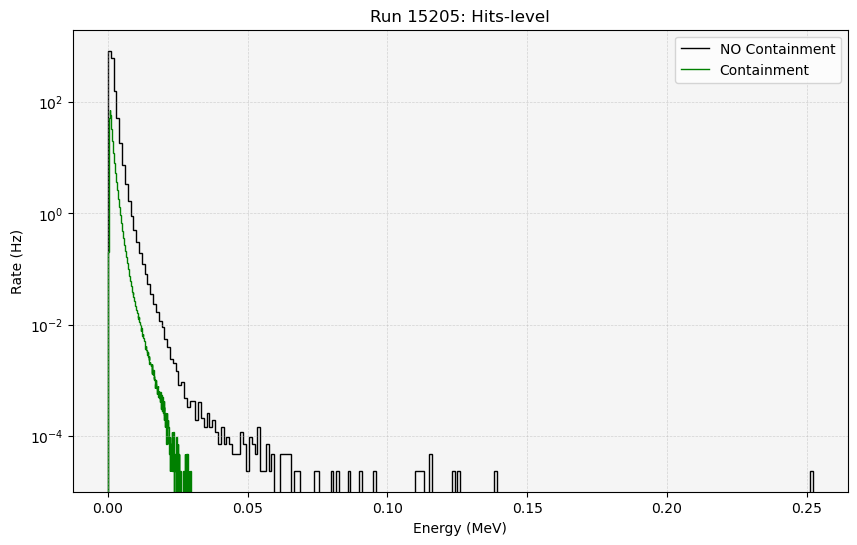

In [46]:
# Global
n_bins = 250

plt.figure(figsize=(10, 6))
color_idx = 0

for label, dataset in zip(['NO Containment', 'Containment'], [data_reco, data_reco_CC]):

    # Variables
    E = dataset['Ec_LT']

    # Histogram: normalized by corrected DAQ data taking time
    E_counts, E_edges = np.histogram(E, bins=n_bins)
    E_rate = E_counts / (run_long * run_DAQe)

    # ----- Plotting ----- #
    plt.stairs(E_rate, E_edges, label=label,
               fill=False, lw=1.0, ec=pt.hist_colors[(color_idx*3) % len(pt.hist_colors)]) 
    color_idx += 1

# Styling
plt.xlabel('Energy (MeV)')
# plt.xlim(0, 0.15)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title(f'Run {run_id}: Hits-level')
plt.legend(loc='best')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

### Events

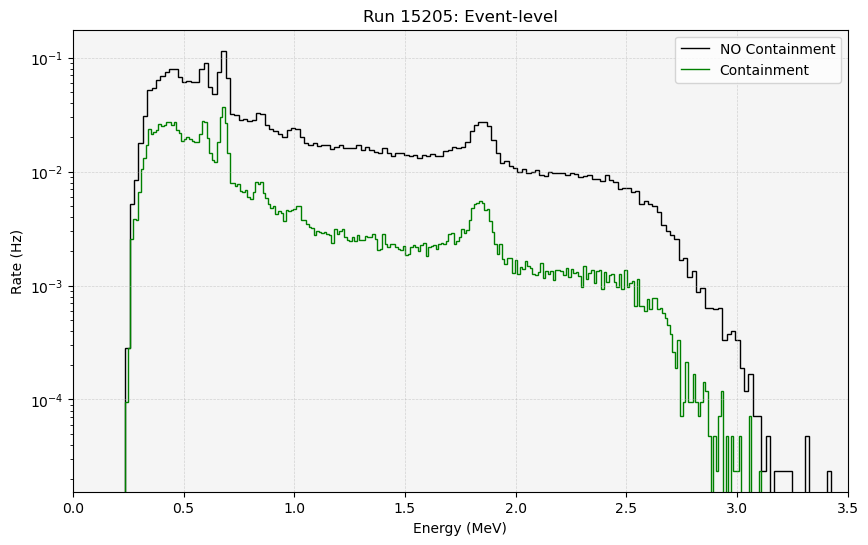

In [47]:
# Global
n_bins = 250

plt.figure(figsize=(10, 6))
color_idx = 0

for label, dataset in zip(['NO Containment', 'Containment'], [data_event, data_event_CC]):

    # Variables
    E = dataset['E']

    # Histogram: normalized by corrected DAQ data taking time
    E_counts, E_edges = np.histogram(E, bins=n_bins)
    E_rate = E_counts / (run_long * run_DAQe)

    # ----- Plotting ----- #
    plt.stairs(E_rate, E_edges, label=label,
               fill=False, lw=1.0, ec=pt.hist_colors[(color_idx*3) % len(pt.hist_colors)]) 
    color_idx += 1

# Styling
plt.xlabel('Energy (MeV)')
plt.xlim(0, 3.5)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title(f'Run {run_id}: Event-level')
plt.legend(loc='best')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

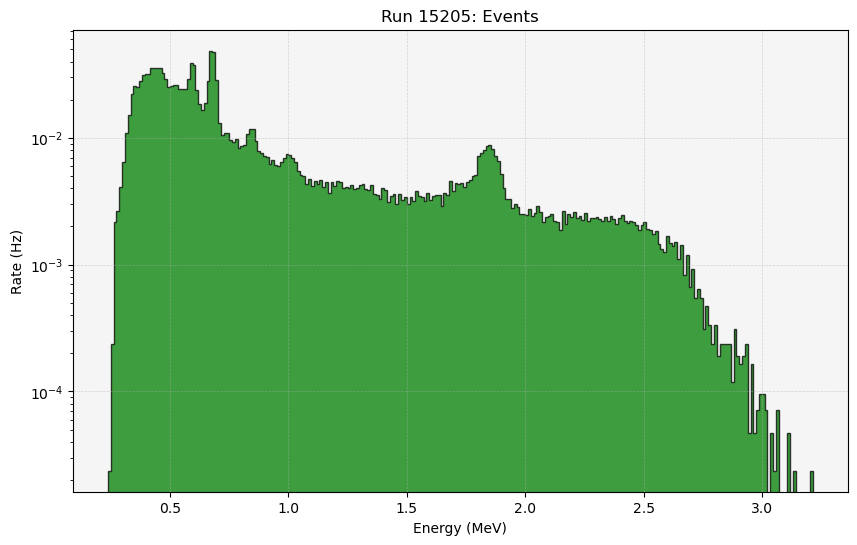

In [67]:
# Global
n_bins = 250

# Variables
E = data_event['E']

# Histogram: normalized by corrected DAQ data taking time
E_counts, E_edges = np.histogram(E, bins=n_bins)
E_rate = E_counts / (run_long * run_DAQe)

# ----- Plotting ----- #
plt.figure(figsize=(10, 6))
plt.stairs(E_rate, E_edges, 
           fill=True, color=pt.hist_colors[3], alpha=0.75, ec='black', lw=1.0)
    
# Styling
plt.xlabel('Energy (MeV)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title(f'Run {run_id}: Events')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()